# Timeseries classification using LSTM

## Introduction

In this lab exercise, we will apply a simple LSTM to do timeseries classification. 

*The lab is adapted from the example codes on keras.io*

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

2023-12-02 10:35:45.562391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 10:35:47.603878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use LSTM for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
train_data_url = 'https://raw.githubusercontent.com/nyp-sit/iti107/main/session-5/FordA_TRAIN.txt' 
train_df = pd.read_csv(train_data_url, delim_whitespace=True, header=None)
train_df

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,-1.0,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,...,1.715205,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753
3597,1.0,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,...,-0.463329,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755
3598,-1.0,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,...,0.902821,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722
3599,1.0,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,...,1.268671,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709


In [3]:
test_data_url = 'https://raw.githubusercontent.com/nyp-sit/iti107/main/session-5/FordA_TEST.txt'
test_df = pd.read_csv(test_data_url, delim_whitespace=True, header=None)

In [4]:
x_train, y_train = train_df.loc[:,1:].values, train_df.loc[:,0].values
x_test, y_test = test_df.loc[:,1:].values, test_df.loc[:,0].values
# x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3601, 500)
(3601,)
(1320, 500)
(1320,)


## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

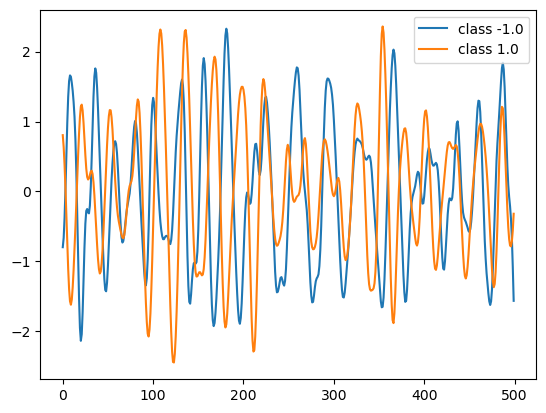

In [6]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [7]:
x_train = np.expand_dims(x_train, axis=2) 
x_test = np.expand_dims(x_test, axis=2) 

In [8]:
x_train.shape

(3601, 500, 1)

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [9]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [10]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [11]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We use a single LSTM layer to capture the temporal information and return the hidden at each timestep.  We then feed these timesteps into the dense layers for classification. 

Note that we set the `return_sequences=True` to return the hidden states at every time-step. The output shape is thus of 3D shape (batch, time-steps, feature). To apply Dense layer to every time step, we use keras TimeDistributed wrapper.  To connect to final Dense layer, we need to Flatten this to a 2D shape (batch, features). 

In [12]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.LSTM(32, return_sequences=True)(input_layer)
    x = keras.layers.LSTM(32, return_sequences=True)(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(16, activation='relu'))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Flatten()(x)
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train.shape[1:])
model.summary()

2023-12-02 10:35:57.221807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 10:35:57.602297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 10:35:57.602357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 10:35:57.606745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 10:35:57.606812: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 500, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 500, 32)           8320      
                                                                 
 time_distributed (TimeDist  (None, 500, 16)           528       
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 500, 16)           0         
                                                                 
 flatten (Flatten)           (None, 8000)              0         
                                                             

## Train the model

In [ ]:
import os 

epochs = 250
batch_size = 256

def create_tb_callback(): 

    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
        import time
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = keras.callbacks.TensorBoard(run_logdir)

    return tb_callback


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=50, restore_best_weights=True
    ),
#     keras.callbacks.ModelCheckpoint(
#         "best_model", save_best_only=True, monitor="val_accuracy"
#     ),
    
    create_tb_callback()
]
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

## Evaluate model on test data

In [14]:
# model = keras.models.load_model("best_model")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 4s 65ms/step - loss: 0.2822 - accuracy: 0.9121
Test accuracy 0.9121212363243103
Test loss 0.2822306454181671


## Visualize training using Tensorboard

In [15]:
%load_ext tensorboard

%tensorboard --logdir tb_logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-12-02 10:46:18.739614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 10:46:19.501037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-02 10:46:20.368464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 10:46:20.394992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 10:4

We can see how the training accuracy reaches almost 1 after 100 epochs.
However, the validation accuracy is stuck at around 0.88. The model is clearly overfitting. Try experimenting with other regularization methods such as L1/L2. 